# Time Series Forecasting with Transformer in PyTorch
This notebook demonstrates how to use a simple Transformer architecture for time series forecasting using PyTorch.

In [1]:
# Import required libraries
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from data_utils import generate_sine_wave
from transformer_model import TimeSeriesTransformer

In [2]:
# Hyperparameters
SEQ_LENGTH = 20
NUM_SAMPLES = 1000
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.001

In [3]:
# Generate data
X, y = generate_sine_wave(SEQ_LENGTH, NUM_SAMPLES)
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [4]:
# Convert to tensors and create DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [5]:
# Model, optimizer, and loss function
model = TimeSeriesTransformer(input_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [6]:
# Training loop using DataLoader
temp_dir = "temp_models"
os.makedirs(temp_dir, exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
    
    # Save model for each epoch in temp_models folder with datetime and class name in filename
    dt_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_name = type(model).__name__
    torch.save(model.state_dict(), os.path.join(temp_dir, f"{model_name}_epoch_{epoch+1}_{dt_str}.pth"))

Epoch 1/20, Loss: 0.2867
Epoch 2/20, Loss: 0.0795
Epoch 2/20, Loss: 0.0795
Epoch 3/20, Loss: 0.0586
Epoch 3/20, Loss: 0.0586
Epoch 4/20, Loss: 0.0588
Epoch 4/20, Loss: 0.0588
Epoch 5/20, Loss: 0.0561
Epoch 5/20, Loss: 0.0561
Epoch 6/20, Loss: 0.0552
Epoch 6/20, Loss: 0.0552
Epoch 7/20, Loss: 0.0547
Epoch 7/20, Loss: 0.0547
Epoch 8/20, Loss: 0.0545
Epoch 8/20, Loss: 0.0545
Epoch 9/20, Loss: 0.0541
Epoch 9/20, Loss: 0.0541
Epoch 10/20, Loss: 0.0554
Epoch 10/20, Loss: 0.0554
Epoch 11/20, Loss: 0.0570
Epoch 11/20, Loss: 0.0570
Epoch 12/20, Loss: 0.0552
Epoch 12/20, Loss: 0.0552
Epoch 13/20, Loss: 0.0578
Epoch 13/20, Loss: 0.0578
Epoch 14/20, Loss: 0.0569
Epoch 14/20, Loss: 0.0569
Epoch 15/20, Loss: 0.0540
Epoch 15/20, Loss: 0.0540
Epoch 16/20, Loss: 0.0571
Epoch 16/20, Loss: 0.0571
Epoch 17/20, Loss: 0.0527
Epoch 17/20, Loss: 0.0527
Epoch 18/20, Loss: 0.0547
Epoch 18/20, Loss: 0.0547
Epoch 19/20, Loss: 0.0535
Epoch 19/20, Loss: 0.0535
Epoch 20/20, Loss: 0.0559
Epoch 20/20, Loss: 0.0559


In [7]:
# Evaluation and prediction using DataLoader
model.eval()
preds = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_x)
        preds.append(output.cpu().numpy())
        true_vals.append(batch_y.cpu().numpy())
preds = np.concatenate(preds)
true_vals = np.concatenate(true_vals)
test_loss = criterion(torch.tensor(preds), torch.tensor(true_vals)).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0508


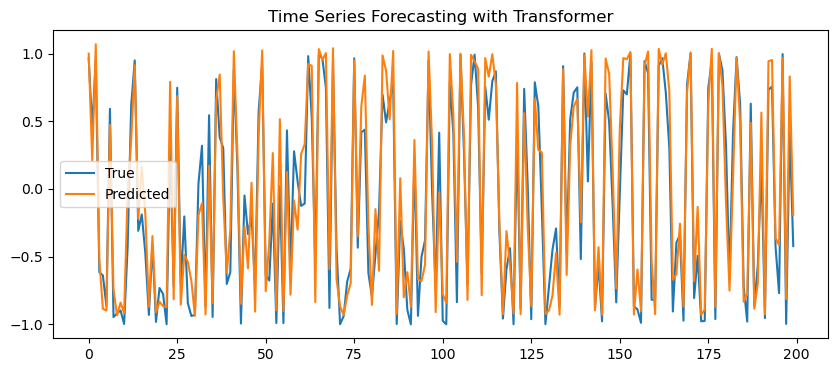

In [8]:
# Plot predictions
plt.figure(figsize=(10,4))
plt.plot(true_vals, label='True')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('Time Series Forecasting with Transformer')
plt.show()

MAE: 0.1861
RMSE: 0.2254
R²: 0.9011


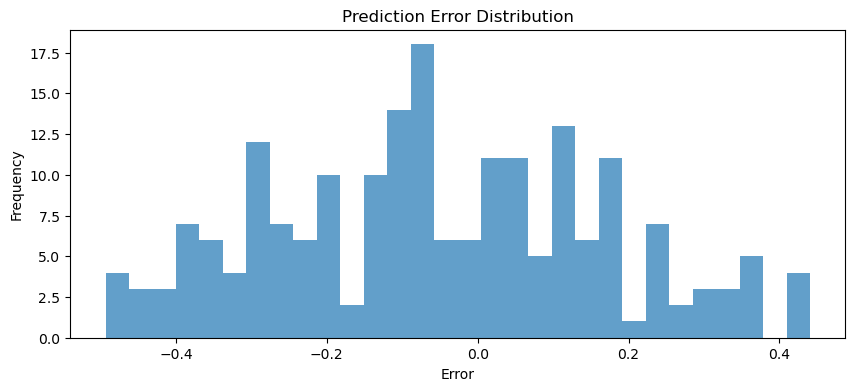

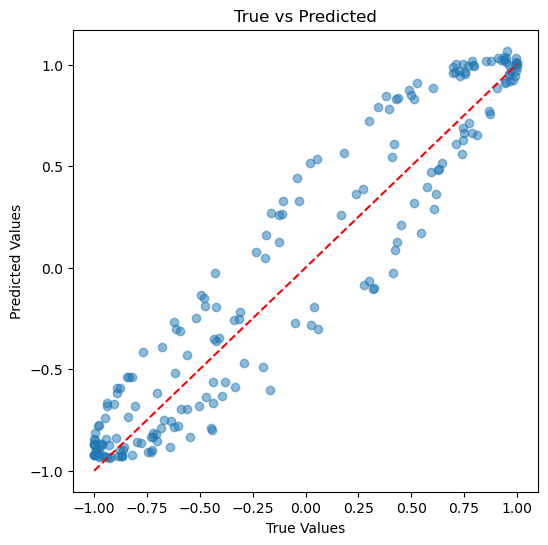

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_regression_insight(true, pred):
    # Calculate regression metrics
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    # Plot prediction errors
    errors = true - pred
    plt.figure(figsize=(10,4))
    plt.hist(errors, bins=30, alpha=0.7)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

    # Scatter plot: True vs Predicted
    plt.figure(figsize=(6,6))
    plt.scatter(true, pred, alpha=0.5)
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted')
    plt.show()

plot_regression_insight(true_vals, preds)

In [10]:
# To load the model later
latest_model_path = sorted([os.path.join(temp_dir, f) for f in os.listdir(temp_dir)], key=os.path.getmtime)[-1]
loaded_model = TimeSeriesTransformer(input_size=1).to(device)
loaded_model.load_state_dict(torch.load(latest_model_path))
loaded_model.eval()
print("Loaded model:", os.path.basename(latest_model_path))
# print(loaded_model)

Loaded model: TimeSeriesTransformer_epoch_20_20250905_160737.pth


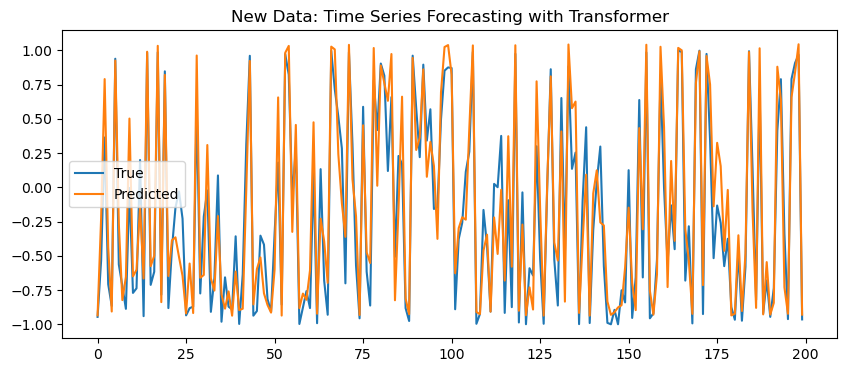

In [11]:
# Generate new test data
X_new, y_new = generate_sine_wave(SEQ_LENGTH, 200)
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
y_new_tensor = torch.tensor(y_new, dtype=torch.float32).to(device)

# Evaluate model on new data
model.eval()
with torch.no_grad():
    preds_new = model(X_new_tensor).cpu().numpy()
    true_new = y_new_tensor.cpu().numpy()

# Plot new predictions
plt.figure(figsize=(10,4))
plt.plot(true_new, label='True')
plt.plot(preds_new, label='Predicted')
plt.legend()
plt.title('New Data: Time Series Forecasting with Transformer')
plt.show()

MAE: 0.1972
RMSE: 0.2434
R²: 0.8725


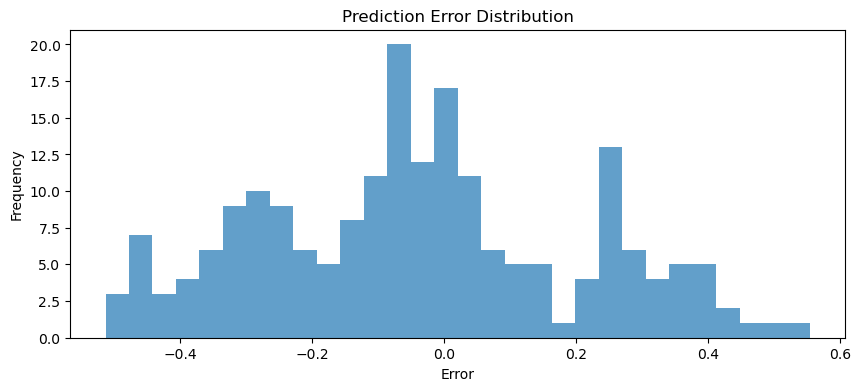

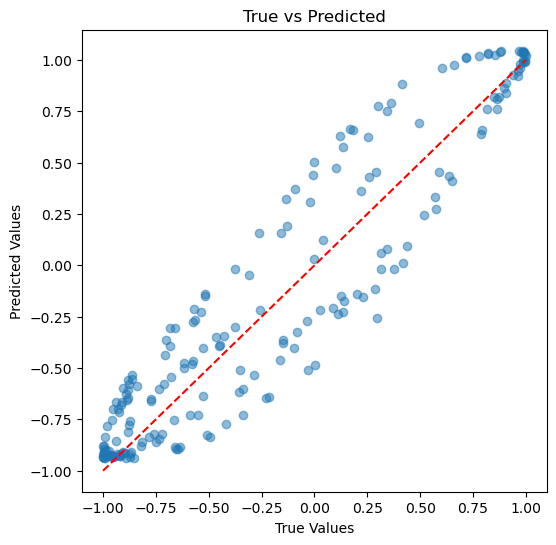

In [12]:
plot_regression_insight(true_new, preds_new)